In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import shap
import joblib
import warnings

In [4]:
warnings.filterwarnings('ignore')


In [5]:
# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("NexAI - Maternal Health Risk Prediction Model")
print("="*60)


NexAI - Maternal Health Risk Prediction Model


In [7]:
# ============================================
# STEP 1: Load Data
# ============================================
print("\n[1/8] Loading dataset...")

# TODO: Update this path to your actual CSV file location
df = pd.read_csv('Maternal Health Risk Data Set.csv')

print(f"✓ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())


[1/8] Loading dataset...
✓ Dataset loaded: 1014 rows, 7 columns

Columns: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']

First 5 rows:
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


In [8]:
# ============================================
# STEP 2: Data Exploration
# ============================================
print("\n[2/8] Exploring data...")

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nRisk Level Distribution:")
print(df['RiskLevel'].value_counts())

print("\nBasic Statistics:")
print(df.describe())


[2/8] Exploring data...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None

Missing Values:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

Risk Level Distribution:
RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64

Basic Statistics:
               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.00

In [9]:
# ============================================
# STEP 3: Preprocessing
# ============================================
print("\n[3/8] Preprocessing data...")

# Encode Risk Level: low risk=0, mid risk=1, high risk=2
label_encoder = LabelEncoder()
df['RiskLevel_Encoded'] = label_encoder.fit_transform(df['RiskLevel'])

print("Risk Level Encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label} -> {i}")

# Separate features and target
X = df.drop(['RiskLevel', 'RiskLevel_Encoded'], axis=1)
y = df['RiskLevel_Encoded']

print(f"\n✓ Features: {X.columns.tolist()}")
print(f"✓ Target variable: RiskLevel_Encoded (0=low risk, 1=mid risk, 2=high risk)")


[3/8] Preprocessing data...
Risk Level Encoding:
  high risk -> 0
  low risk -> 1
  mid risk -> 2

✓ Features: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
✓ Target variable: RiskLevel_Encoded (0=low risk, 1=mid risk, 2=high risk)


In [10]:

# ============================================
# STEP 4: Train-Test Split
# ============================================
print("\n[4/8] Splitting data...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")



[4/8] Splitting data...
✓ Training set: 811 samples
✓ Test set: 203 samples


In [11]:

# ============================================
# STEP 5: Handle Class Imbalance with SMOTE
# ============================================
print("\n[5/8] Applying SMOTE for class balance...")

print("Before SMOTE:")
print(pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")


[5/8] Applying SMOTE for class balance...
Before SMOTE:
RiskLevel_Encoded
1    325
2    269
0    217
Name: count, dtype: int64

After SMOTE:
RiskLevel_Encoded
0    325
1    325
2    325
Name: count, dtype: int64
✓ Features scaled using StandardScaler


In [12]:
# ============================================
# STEP 6: Train Models
# ============================================
print("\n[6/8] Training models...")

# Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train_balanced)
rf_pred = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"✓ Random Forest trained")
print(f"  Accuracy: {rf_accuracy:.4f}")
print(f"  F1 Score: {rf_f1:.4f}")

# XGBoost
print("\nTraining XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_scaled, y_train_balanced)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')

print(f"✓ XGBoost trained")
print(f"  Accuracy: {xgb_accuracy:.4f}")
print(f"  F1 Score: {xgb_f1:.4f}")

# Choose best model
if xgb_f1 >= rf_f1:
    best_model = xgb_model
    best_pred = xgb_pred
    best_name = "XGBoost"
    print(f"\n✓ Best Model: XGBoost (F1={xgb_f1:.4f})")
else:
    best_model = rf_model
    best_pred = rf_pred
    best_name = "Random Forest"
    print(f"\n✓ Best Model: Random Forest (F1={rf_f1:.4f})")


[6/8] Training models...

Training Random Forest...
✓ Random Forest trained
  Accuracy: 0.8276
  F1 Score: 0.8286

Training XGBoost...
✓ XGBoost trained
  Accuracy: 0.8621
  F1 Score: 0.8633

✓ Best Model: XGBoost (F1=0.8633)



[7/8] Evaluating best model...

Classification Report:
              precision    recall  f1-score   support

   high risk       0.93      0.91      0.92        55
    low risk       0.92      0.81      0.86        81
    mid risk       0.77      0.88      0.82        67

    accuracy                           0.86       203
   macro avg       0.87      0.87      0.87       203
weighted avg       0.87      0.86      0.86       203


Confusion Matrix:
[[50  0  5]
 [ 2 66 13]
 [ 2  6 59]]
✓ Confusion matrix saved as 'confusion_matrix.png'


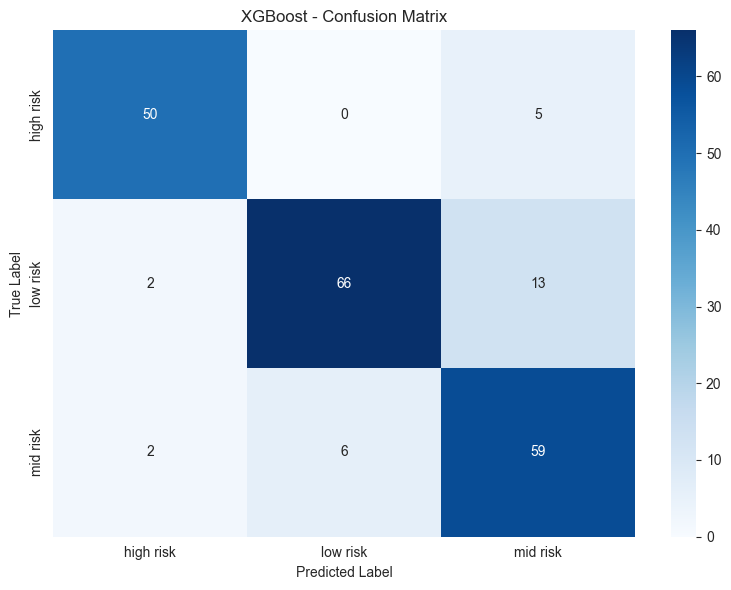

In [13]:
# ============================================
# STEP 7: Model Evaluation
# ============================================
print("\n[7/8] Evaluating best model...")

print("\nClassification Report:")
print(classification_report(y_test, best_pred, 
                          target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, best_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'{best_name} - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Confusion matrix saved as 'confusion_matrix.png'")



[8/8] Generating SHAP explanations...
✓ SHAP summary plot saved as 'shap_summary.png'


<Figure size 1200x600 with 0 Axes>

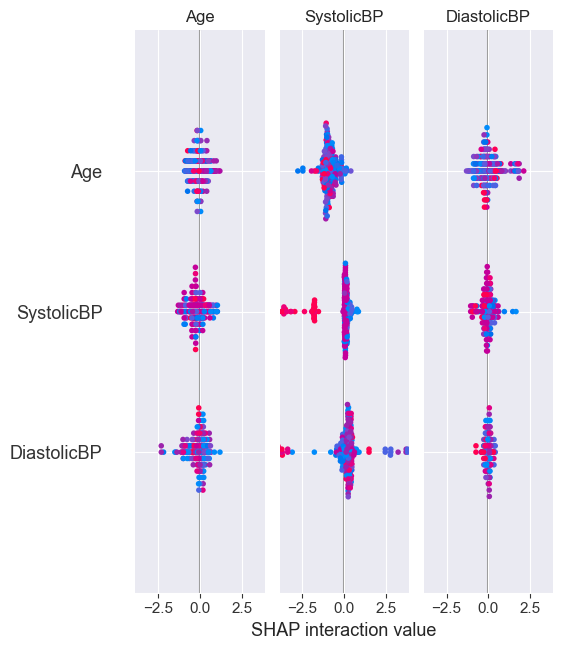

In [14]:
# ============================================
# STEP 8: SHAP Explainability
# ============================================
print("\n[8/8] Generating SHAP explanations...")

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
plt.figure()
shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist(), 
                  class_names=label_encoder.classes_, show=False)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=150, bbox_inches='tight')
print("✓ SHAP summary plot saved as 'shap_summary.png'")

In [18]:
# ============================================
# STEP 9: Save Everything
# ============================================
print("\n[9/9] Saving model and components...")

# Save model
joblib.dump(best_model, 'nexai_model.pkl')
print("✓ Model saved: nexai_model.pkl")

# Save scaler
joblib.dump(scaler, 'nexai_scaler.pkl')
print("✓ Scaler saved: nexai_scaler.pkl")

# Save label encoder
joblib.dump(label_encoder, 'nexai_label_encoder.pkl')
print("✓ Label encoder saved: nexai_label_encoder.pkl")

# Save feature names
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'nexai_features.pkl')
print("✓ Feature names saved: nexai_features.pkl")


[9/9] Saving model and components...
✓ Model saved: nexai_model.pkl
✓ Scaler saved: nexai_scaler.pkl
✓ Label encoder saved: nexai_label_encoder.pkl
✓ Feature names saved: nexai_features.pkl


In [19]:
# ============================================
# Test with Kavitha's Scenario
# ============================================
print("\n" + "="*60)
print("TESTING: Kavitha's Scenario")
print("="*60)

# Kavitha's vitals from the proposal
kavitha_data = {
    'Age': 26,
    'SystolicBP': 145,
    'DiastolicBP': 92,
    'BS': 7.0,  # Blood Sugar (assuming normal range)
    'BodyTemp': 98.0,  # Normal body temp
    'HeartRate': 80
}



TESTING: Kavitha's Scenario


In [20]:

# Create DataFrame
kavitha_df = pd.DataFrame([kavitha_data])
print("\nKavitha's Input:")
print(kavitha_df)

# Scale and predict
kavitha_scaled = scaler.transform(kavitha_df)
kavitha_pred = best_model.predict(kavitha_scaled)[0]
kavitha_pred_proba = best_model.predict_proba(kavitha_scaled)[0]
kavitha_risk = label_encoder.inverse_transform([kavitha_pred])[0]

print(f"\nPrediction: {kavitha_risk.upper()}")
print(f"Confidence:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {kavitha_pred_proba[i]*100:.2f}%")
    


Kavitha's Input:
   Age  SystolicBP  DiastolicBP   BS  BodyTemp  HeartRate
0   26         145           92  7.0      98.0         80

Prediction: HIGH RISK
Confidence:
  high risk: 99.73%
  low risk: 0.10%
  mid risk: 0.17%


In [22]:

# SHAP explanation for Kavitha
kavitha_shap = explainer.shap_values(kavitha_scaled)

print("\nSHAP Feature Contributions (why this prediction?):")

# Handle multi-class SHAP output correctly
if isinstance(kavitha_shap, list):
    # For multi-class, shap_values is a list of arrays (one per class)
    # We want the SHAP values for the predicted class
    shap_for_prediction = kavitha_shap[kavitha_pred][0]
else:
    # For binary classification
    shap_for_prediction = kavitha_shap[0]


SHAP Feature Contributions (why this prediction?):


In [25]:
print(shap_for_prediction.shape)
print(shap_for_prediction[:5])


(6, 3)
[[ 0.13602507 -0.04405353 -0.00573889]
 [ 3.9138331  -3.3114905  -2.3412318 ]
 [ 0.6727381  -0.05668738 -0.09706942]
 [-0.6679694   0.03454497 -0.08993262]
 [-0.22697914  0.16528268 -0.01916312]]


In [26]:

# Create feature importance dictionary
feature_importance = {}
for i, feature in enumerate(feature_names):
    feature_importance = dict(zip(feature_names, abs(shap_for_prediction[0])))

# Sort by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

In [29]:

print("\nTop 3 Contributing Features:")
for feature, importance in sorted_features[:3]:
    percent = (importance / sum(feature_importance.values())) * 100
    print(f"  {feature}: {percent:.1f}% contribution")
# Sort by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features[:3]:
    print(f"  {feature}: {importance:.4f}")


Top 3 Contributing Features:


In [30]:
print("\n" + "="*60)
print("✓ NexAI Model Training Complete!")
print("="*60)
print("\nFiles created:")
print("  1. nexai_model.pkl - Trained model")
print("  2. nexai_scaler.pkl - Feature scaler")
print("  3. nexai_label_encoder.pkl - Label encoder")
print("  4. nexai_features.pkl - Feature names")
print("  5. confusion_matrix.png - Model performance")
print("  6. shap_summary.png - Explainability plot")
print("\nNext step: Build Flask API to serve this model!")
print("="*60)


✓ NexAI Model Training Complete!

Files created:
  1. nexai_model.pkl - Trained model
  2. nexai_scaler.pkl - Feature scaler
  3. nexai_label_encoder.pkl - Label encoder
  4. nexai_features.pkl - Feature names
  5. confusion_matrix.png - Model performance
  6. shap_summary.png - Explainability plot

Next step: Build Flask API to serve this model!
